In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
import time
from qutip.ui.progressbar import BaseProgressBar

In [2]:
### DEFINE SYSTEM OPERATORS
N = 2 #for spin 1/2
N_spin = 4

qeye_list = [qeye(N) for i in range(N_spin)] #identity matrices
sigmax_list = [] #list of pauli operators for each spin
sigmay_list = []
sigmaz_list = []

for i in range(N_spin): #setup list of annihilation operators
    '''
    E.g. For three oscillators, this builds the list 
    [tensor(a,qeye,qeye), tensor(qeye,a,qeye), tensor(qeye,qeye,a)]
    '''
    
    # Pauli-X operator for the i-th spin
    temp1 = qeye_list.copy()
    temp1[i] = sigmax() 
    sigmax_list.append(tensor(temp1))
    
    # Pauli-Y operator for the i-th spin
    temp2 = qeye_list.copy()
    temp2[i] = sigmay() 
    sigmay_list.append(tensor(temp2))
    
    # Pauli-Z operator for the i-th spin
    temp3 = qeye_list.copy()
    temp3[i] = sigmaz() 
    sigmaz_list.append(tensor(temp3))

In [3]:
def spin_chain_H(N_spin, J, h, sigmax_list, sigmay_list, sigmaz_list):
    """
    Constructs the Hamiltonian for an XY spin chain with a transverse field.

    Parameters:
    N_spin (int): Number of spins in the chain.
    J (float): Interaction strength between neighboring spins.
    h (float): Strength of the transverse field.
    sigmax_list (list): List of Pauli-X operators for each spin.
    sigmay_list (list): List of Pauli-Y operators for each spin.
    sigmaz_list (list): List of Pauli-Z operators for each spin.

    Returns:
    Qobj: The Hamiltonian of the spin chain as a Qobj instance.
    """
    H_int = 0
    for j in range(N_spin-1):
        H_int += J/2 * (sigmax_list[j]*sigmax_list[j+1] + sigmay_list[j]*sigmay_list[j+1])
    
    H_field = 0
    for j in range(N_spin):
        H_field += h * sigmaz_list[j]
        
    return H_int + H_field

In [5]:
from qutip import SMESolver, parallel_map, fock, tensor

def stochastic_solve(H, gamma, times, sigmaz_list, N_spin, ntraj=50, nsubsteps=50):
    """
    Solve the stochastic master equation for a given Hamiltonian using homodyne detection.

    Parameters:
    H (Qobj): Hamiltonian of the system.
    gamma (float): Measurement rate.
    times (array-like): Array of time points for the evolution.
    sigmaz_list (list): List of Pauli-Z operators for each spin.
    N_spin (int): Number of spins in the system.
    ntraj (int): Number of trajectories for the stochastic simulation (default is 50).
    nsubsteps (int): Number of substeps for each time step in the solver (default is 50).

    Returns:
    Result: Result object from the stochastic master equation solver.
    """
    
    # Lindblad operator for homodyne detection
    L = np.sqrt(gamma) * sigmaz_list[2]
    
    # Initial state: tensor product of fock states
    rho0 = tensor([fock(2, 1), fock(2,0), fock(2,0), fock(2,0)])
    
    # Collapse operators and stochastic collapse operators
    c_ops = []
    sc_ops = [L]
    
    # Expectation value operators
    e_ops = [sigmaz_list[0], sigmaz_list[-1]]

    options = {
        "store_final_state": True,
        "store_states": True,
        "store_measurement": True,
        "normalize_output": True,
        "method": "platen",
        "map": "parallel",
        "progress_bar": "text",
        # "keep_runs_results": True
    }
    # Create the SMESolver
    sol = SMESolver(
        H, sc_ops=sc_ops, c_ops=c_ops, options=options, heterodyne=False
    )
    
    # Set measurement operators and Wiener process factors
    sol.m_ops = [L + L.dag()]
    sol.dW_factors = [1 / np.sqrt(gamma)]
    
    # Run the stochastic master equation solver
    result = sol.run(
        rho0, tlist=times, ntraj=ntraj, e_ops=e_ops
    )
    return result

In [ ]:
H = spin_chain_H(N_spin, np.pi, 1, sigmax_list, sigmay_list, sigmaz_list)
gamma = 0.0001
times = np.linspace(0,50,1000)
result = stochastic_solve(H, gamma, times, sigmaz_list, N_spin, ntraj=500)

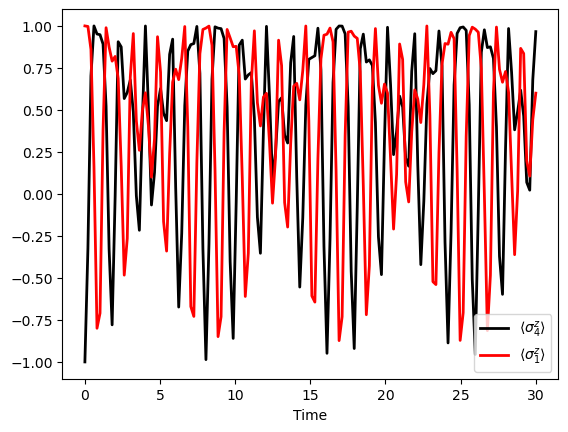

In [7]:
fig, ax = plt.subplots()
# ax.set_title('Stochastic Master Equation - Homodyne Detection')
# ax.plot(times[1:], np.array(result.measurement).mean(axis=0)[0, :].real,
#         'r', lw=2, label=r'$L$')
start = 0
end = 150
ax.plot(times[start:end], result.expect[0][start:end], color='black', lw=2,
        label=r'$\langle \sigma_4^z \rangle$')
ax.plot(times[start:end], result.expect[1][start:end], color='red', lw=2,
        label=r'$\langle \sigma_1^z \rangle$')
ax.set_xlabel('Time')
ax.legend()

In [13]:
H = spin_chain_H(N_spin, np.pi, 1, sigmax_list, sigmay_list, sigmaz_list)
gamma = 0.7
times = np.linspace(0,40,200)
result1 = stochastic_solve(H, gamma, times, sigmaz_list, N_spin)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
# ax.set_title('Stochastic Master Equation - Homodyne Detection')
ax.plot(times[1:], np.array(result1.measurement).mean(axis=0)[0, :].real,
        'r', lw=2, label=r'$L$')
ax.plot(times, result1.expect[0].mean(axis=0), 'k', lw=2,
        label=r'$\langle \sigma_4^z \rangle$')
ax.plot(times, result1.expect[1].mean(axis=0), 'k', lw=2,
        label=r'$\langle \sigma_1^z \rangle$')
ax.set_xlabel('Time')
ax.legend()